<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/adanet/adanet_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import adanet

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [0]:
# Load dataset
(x_train, labels_train), (x_test, labels_test) = tf.keras.datasets.cifar10.load_data()

print(f'x_train shape: {x_train.shape}')
print(f'labels_train shape: {labels_train.shape}')
print(f'x_test  shape: {x_test.shape}')
print(f'labels_test  shape: {labels_test.shape}')

x_train shape: (50000, 32, 32, 3)
labels_train shape: (50000, 1)
x_test  shape: (10000, 32, 32, 3)
labels_test  shape: (10000, 1)


In [0]:
x_train = x_train / 255 # normalize data
x_test  = x_test / 255  # normalize data

x_train = x_train.astype(np.float32) # cast to float32
x_test = x_test.astype(np.float32)   # cast to float32

labels_train = labels_train.astype(np.int32) # cast to int32
labels_test = labels_test.astype(np.int32)   # cast to int32

In [0]:
TRAIN_SIZE = x_train.shape[0]
EPOCHS = 10
BATCH_SIZE=32
LEARNING_RATE = 0.001

In [0]:
def show_images(rows=5, columns=5):
    """Prints a set of images."""

    for i in range(columns):
        for j in range(rows):
            index = j * columns + i + 1
            plt.subplot(rows, columns, index)
            plt.imshow(x_train[index-1])
    plt.show()

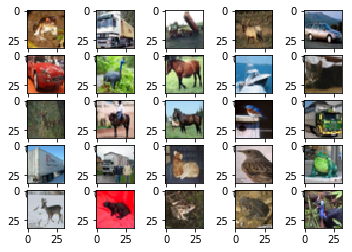

In [0]:
show_images()

In [0]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=BATCH_SIZE,
    num_epochs=EPOCHS,
    shuffle=True)

adanet_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=labels_train,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=labels_test,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False)

In [0]:
# 

def cnn_model(features, labels, mode, params):
    images = list(features.values())[0]
    
    x = Conv2D(32, kernel_size=7, activation='relu')(images)
    x = MaxPooling2D(strides=2)(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    logits = Dense(10)(x)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.0)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
classifier = tf.estimator.Estimator(model_fn=cnn_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmpy9l152hp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb2c3a94a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
MAX_STEPS = TRAIN_SIZE * EPOCHS // BATCH_SIZE

results, _ = tf.estimator.train_and_evaluate(
    classifier,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=MAX_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmpy9l152hp/model.ckpt.
INFO:tensorflow:loss = 2.3518612, step = 1
INFO:ten

INFO:tensorflow:loss = 1.3904434, step = 6501 (1.907 sec)
INFO:tensorflow:global_step/sec: 51.92
INFO:tensorflow:loss = 2.2226858, step = 6601 (1.926 sec)
INFO:tensorflow:global_step/sec: 52.5103
INFO:tensorflow:loss = 4.506811, step = 6701 (1.904 sec)
INFO:tensorflow:global_step/sec: 50.893
INFO:tensorflow:loss = 2.371473, step = 6801 (1.965 sec)
INFO:tensorflow:global_step/sec: 50.8176
INFO:tensorflow:loss = 2.979251, step = 6901 (1.968 sec)
INFO:tensorflow:global_step/sec: 52.1259
INFO:tensorflow:loss = 2.1790307, step = 7001 (1.918 sec)
INFO:tensorflow:global_step/sec: 52.3832
INFO:tensorflow:loss = 2.7649, step = 7101 (1.909 sec)
INFO:tensorflow:global_step/sec: 51.4114
INFO:tensorflow:loss = 2.3516412, step = 7201 (1.945 sec)
INFO:tensorflow:global_step/sec: 51.8235
INFO:tensorflow:loss = 4.1638207, step = 7301 (1.930 sec)
INFO:tensorflow:global_step/sec: 52.008
INFO:tensorflow:loss = 3.0381882, step = 7401 (1.923 sec)
INFO:tensorflow:global_step/sec: 53.0091
INFO:tensorflow:loss

INFO:tensorflow:loss = 3.3519416, step = 14801 (2.026 sec)
INFO:tensorflow:global_step/sec: 49.2628
INFO:tensorflow:loss = 3.5327277, step = 14901 (2.030 sec)
INFO:tensorflow:global_step/sec: 48.3998
INFO:tensorflow:loss = 5.2676, step = 15001 (2.066 sec)
INFO:tensorflow:global_step/sec: 52.0411
INFO:tensorflow:loss = 2.6611755, step = 15101 (1.922 sec)
INFO:tensorflow:global_step/sec: 54.3288
INFO:tensorflow:loss = 3.8642845, step = 15201 (1.841 sec)
INFO:tensorflow:global_step/sec: 52.6145
INFO:tensorflow:loss = 2.2586288, step = 15301 (1.901 sec)
INFO:tensorflow:global_step/sec: 51.24
INFO:tensorflow:loss = 3.069327, step = 15401 (1.951 sec)
INFO:tensorflow:global_step/sec: 51.2622
INFO:tensorflow:loss = 2.548195, step = 15501 (1.951 sec)
INFO:tensorflow:global_step/sec: 52.0692
INFO:tensorflow:loss = 6.2818756, step = 15601 (1.920 sec)
INFO:tensorflow:Saving checkpoints for 15625 into /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmpy9l152hp/model.ckpt.
INFO:tensorflow:Calling m

In [0]:
print("Accuracy:", results["accuracy"])
print("Loss:", results["loss"])

Accuracy: 0.3715
Loss: 4.911181


In [0]:
# base code: https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb

class CNNBuilder(adanet.subnetwork.Builder):
    def __init__(self, n_convs):
        self._n_convs = n_convs
        
    def build_subnetwork(self,
                         features,
                         logits_dimension,
                         training,
                         iteration_step,
                         summary,
                         previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""
        images = list(features.values())[0]
        x = images
    
        for i in range(self._n_convs):
            x = Conv2D(32, kernel_size=7, activation='relu')(x)
            x = MaxPooling2D(strides=2)(x)
        
        x = Flatten()(x)
        x = Dense(100, activation='relu')(x)
        
        logits = Dense(10)(x)

        complexity = tf.constant(self._n_convs + 1)

        persisted_tensors = {'n_convs': tf.constant(self._n_convs)}
        
        return adanet.Subnetwork(
            last_layer=x,
            logits=logits,
            complexity=complexity,
            persisted_tensors=persisted_tensors)
    
    def build_subnetwork_train_op(self,
                                subnetwork,
                                loss,
                                var_list,
                                labels,
                                iteration_step,
                                summary,
                                previous_ensemble=None):
        """See `adanet.subnetwork.Builder`."""

        optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.0)
        # NOTE: The `adanet.Estimator` increments the global step.
        return optimizer.minimize(loss=loss, var_list=var_list)

    def build_mixture_weights_train_op(self, loss, var_list, logits, labels,
                                     iteration_step, summary):
        """See `adanet.subnetwork.Builder`."""
        return tf.no_op("mixture_weights_train_op")

    @property
    def name(self):
        """See `adanet.subnetwork.Builder`."""
        if self._n_convs == 0:
            return 'dense'
        return f'cnn_{self._n_convs}'

In [0]:
class CNNGenerator(adanet.subnetwork.Generator):
    """Generates a `CNN` at each iteration.
    """

    def __init__(self):
        """Initializes a `Generator` that builds `SimpleCNNs`.

        Args:
          learning_rate: The float learning rate to use.
          max_iteration_steps: The number of steps per iteration.
          seed: The random seed.

        Returns:
          An instance of `Generator`.
        """
        self._cnn_builder_fn = CNNBuilder

    def generate_candidates(self, previous_ensemble, iteration_number,
                          previous_ensemble_reports, all_reports):
        """See `adanet.subnetwork.Generator`."""
        n_convs = 0
        if previous_ensemble:
            n_convs = tf.contrib.util.constant_value(
                previous_ensemble.weighted_subnetworks[-1]
                .subnetwork
                .persisted_tensors['n_convs'])

        return [
            self._cnn_builder_fn(n_convs=n_convs),
            self._cnn_builder_fn(n_convs=n_convs + 1)
        ]

In [0]:
N_CLASSES = 10
head = tf.contrib.estimator.multi_class_head(N_CLASSES)

In [0]:
ADANET_STEPS = 2
max_iteration_steps = MAX_STEPS // ADANET_STEPS

In [0]:
estimator = adanet.Estimator(
    head=head,
    subnetwork_generator=CNNGenerator(),
    max_iteration_steps=max_iteration_steps,
    evaluator=adanet.Evaluator(
        input_fn=adanet_input_fn,
        steps=None),
    adanet_loss_decay=.99)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb2d547cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=MAX_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=test_input_fn,
        steps=None))


INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Beginning training AdaNet iteration 0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/model.ckpt.
INFO:tensorflow:loss = 2.3500273, step = 1
INFO:tensorflow:global_step/sec: 44.6849
INFO:tensorflow:loss = 2.030254, step = 101 (2.239 sec)
INFO:tensorflow:global_step/sec: 47.3606
INFO:tensorflow:loss = 2.1959734, step = 201 (2.112 sec)
INFO:ten

INFO:tensorflow:loss = 4.0862827, step = 7601 (2.961 sec)
INFO:tensorflow:global_step/sec: 37.7036
INFO:tensorflow:loss = 3.762403, step = 7701 (2.652 sec)
INFO:tensorflow:global_step/sec: 31.6538
INFO:tensorflow:loss = 1.9889238, step = 7801 (3.161 sec)
INFO:tensorflow:Saving checkpoints for 7812 into /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-03-19:17:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/model.ckpt-7812
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving candidate 'dense' dict for global step 7812: accuracy/adanet/adanet_weighted_ensemble = 0.2637, accuracy/adanet/subnetwork = 0.2637, accuracy/adanet/uniform_average_ensemble = 0.2637, architecture/adanet/ensembles = b"\nU\n5adane

INFO:tensorflow:loss = 2.2855592, step = 11113 (3.158 sec)
INFO:tensorflow:global_step/sec: 41.2293
INFO:tensorflow:loss = 2.927823, step = 11213 (2.426 sec)
INFO:tensorflow:global_step/sec: 43.2958
INFO:tensorflow:loss = 1.9583157, step = 11313 (2.310 sec)
INFO:tensorflow:global_step/sec: 29.5963
INFO:tensorflow:loss = 3.0043955, step = 11413 (3.384 sec)
INFO:tensorflow:global_step/sec: 43.6784
INFO:tensorflow:loss = 2.115023, step = 11513 (2.284 sec)
INFO:tensorflow:global_step/sec: 30.1646
INFO:tensorflow:loss = 2.3868835, step = 11613 (3.315 sec)
INFO:tensorflow:global_step/sec: 28.8772
INFO:tensorflow:loss = 2.9143977, step = 11713 (3.463 sec)
INFO:tensorflow:global_step/sec: 40.9773
INFO:tensorflow:loss = 2.3596308, step = 11813 (2.440 sec)
INFO:tensorflow:global_step/sec: 43.4315
INFO:tensorflow:loss = 2.3355029, step = 11913 (2.302 sec)
INFO:tensorflow:global_step/sec: 47.2259
INFO:tensorflow:loss = 1.9149297, step = 12013 (2.117 sec)
INFO:tensorflow:global_step/sec: 38.705
INF

INFO:tensorflow:Restoring parameters from /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/model.ckpt-15624
INFO:tensorflow:Ensemble evaluation [1000/??]
INFO:tensorflow:Encountered end of input after 1564 evaluations
INFO:tensorflow:Computed ensemble metrics: adanet_loss/previous_ensemble = 3.696327, adanet_loss/dense = 3.043171, adanet_loss/cnn_1 = 2.073254
INFO:tensorflow:Finished ensemble evaluation for iteration 1
INFO:tensorflow:'cnn_1' at index 2 is moving onto the next iteration
INFO:tensorflow:Importing frozen ensemble from /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/frozen/ensemble-0.meta with features: ['x'].
INFO:tensorflow:Freezing best ensemble to /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/frozen/ensemble-1.meta
INFO:tensorflow:Restoring parameters from /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/tmphzc4fdhe/model.ckpt-15624
INFO:tensorflow:Importing frozen ensemble from /var/folders/sy/5v5fz7jj3yv0kpyd9d0bdm7m0000gn/T/t

In [0]:
def ensemble_architecture(result):
    """Extracts the ensemble architecture from evaluation results."""

    architecture = result["architecture/adanet/ensembles"]
    # The architecture is a serialized Summary proto for TensorBoard.
    summary_proto = tf.summary.Summary.FromString(architecture)
    return summary_proto.value[0].tensor.string_val[0]

In [0]:
print("Accuracy:", results["accuracy"])
print("Loss:", results["average_loss"])
print(ensemble_architecture(results))

Accuracy: 0.4156
Loss: 1.7926145
b"| b'dense' | b'cnn_1' | b'cnn_1' |"


Code references:
1. https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/customizing_adanet.ipynb
2. https://github.com/tensorflow/adanet/blob/master/adanet/examples/tutorials/adanet_objective.ipynb
3. https://github.com/tensorflow/models/blob/master/samples/core/get_started/custom_estimator.py